In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# loading the datasets seperately because spliting with indices
# only allows using one element to be selected 
ds_test, ds_test_info = tfds.load(
    'genomics_ood',
    split='test[:1000]',
    shuffle_files=True,
    as_supervised=True, # ds is turned into a tuple
    # if as_supervised=False: will be a dictionary with all the features
    with_info=True,
)

ds_train, ds_train_info = tfds.load(
    'genomics_ood',
    split='train[:100000]',
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [3]:
def transformToHot(Seq, Lab):
    vocab = {"A":"1", "C":"2", "G":"3", "T":"0"}
    for key in vocab.keys():
        Seq = tf.strings.regex_replace(Seq, key, vocab[key])
    split = tf.strings.bytes_split(Seq)
    labels = tf.cast(tf.strings.to_number(split), tf.uint8)
    Seq = tf.one_hot(labels, 4)
    Seq = tf.reshape(Seq, (-1,))

    Lab = tf.one_hot(Lab, 10)
    return Seq, Lab

In [4]:
# buffer size should be the size of the dataset
ds_train = ds_train.shuffle(buffer_size=100000)
ds_train = ds_train.map(transformToHot)
ds_train = ds_train.batch(32)
ds_train = ds_train.cache()
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
# while model is executing training step s
# the pipeline is reading the data for the next step


ds_test = ds_test.map(transformToHot)
ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)


In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

# creating the model
model = tf.keras.Sequential(name="myModel")
model.add(tf.keras.Input(shape=(1000), name="Input"))
model.add(tf.keras.layers.Dense(256, activation=tf.keras.activations.sigmoid, name="hidden_1"))
model.add(tf.keras.layers.Dense(256, activation=tf.keras.activations.sigmoid, name="hidden_2"))
model.add(tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax, name="otuput0"))

# define optimizer (gradient) and loss function 
opt = tf.keras.optimizers.SGD(learning_rate=0.1, name='SGD')
loss_fn = tf.keras.losses.categorical_crossentropy

# save accuracy of each epoch
model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
model.summary()



Model: "myModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 256)               256256    
_________________________________________________________________
hidden_2 (Dense)             (None, 256)               65792     
_________________________________________________________________
otuput0 (Dense)              (None, 10)                2570      
Total params: 324,618
Trainable params: 324,618
Non-trainable params: 0
_________________________________________________________________


### Run with GPU

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # if gpu has low memory this limits the size tf is allowed to use
    # using to much space can lead to breakage
   tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4048)])
  except RuntimeError as e:
   print(e)

with tf.device("/device:GPU:0"):
    history = model.fit(ds_train, epochs=10, validation_data=ds_test)
    # uses validation data to test each epoch

Epoch 1/10
3125/3125 [==============================] - 32s 10ms/step - loss: 1.6011 - accuracy: 0.3129 - val_loss: 1.4794 - val_accuracy: 0.3360
Epoch 2/10
3125/3125 [==============================] - 14s 4ms/step - loss: 1.4890 - accuracy: 0.3531 - val_loss: 1.4668 - val_accuracy: 0.3570
Epoch 3/10
3125/3125 [==============================] - 12s 4ms/step - loss: 1.4747 - accuracy: 0.3637 - val_loss: 1.4605 - val_accuracy: 0.3650
Epoch 4/10
3125/3125 [==============================] - 11s 3ms/step - loss: 1.4667 - accuracy: 0.3686 - val_loss: 1.4567 - val_accuracy: 0.3770
Epoch 5/10
3125/3125 [==============================] - 10s 3ms/step - loss: 1.4618 - accuracy: 0.3715 - val_loss: 1.4543 - val_accuracy: 0.3780
Epoch 6/10
3125/3125 [==============================] - 11s 3ms/step - loss: 1.4583 - accuracy: 0.3743 - val_loss: 1.4528 - val_accuracy: 0.3820
Epoch 7/10
3125/3125 [==============================] - 10s 3ms/step - loss: 1.4554 - accuracy: 0.3763 - val_loss: 1.4520 - val_a

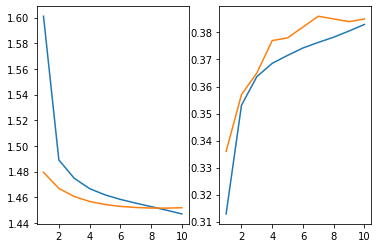

In [7]:
# ploting the resulting data
x_axis = np.arange(1, 11)

# somehow test accuracy is very case sensitive
fig, ax = plt.subplots(1,2)
ax[0].plot(x_axis, history.history["loss"])
ax[0].plot(x_axis, history.history["val_loss"])
ax[1].plot(x_axis, history.history["accuracy"])
ax[1].plot(x_axis, history.history["val_accuracy"])

